Примеры:
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb
* https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb
* http://localhost:8888/notebooks/examples/2/%D0%94%D0%B5%D0%BC%D0%BE%D0%BD%D1%81%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F-BigARTM-0.8.0.ipynb

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [2]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [3]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре"
)


# Фильтрация

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_tf", 
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_tf", 
)

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.01)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_df_rate", 
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.6)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_df_rate", 
)

  75725 - количество слов в словаре
  19855 - количество слов в словаре после фильтрации по min_tf
  19310 - количество слов в словаре после фильтрации по max_tf
   1819 - количество слов в словаре после фильтрации по min_df_rate
   1819 - количество слов в словаре после фильтрации по max_df_rate


In [4]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        # Названия тем
        topic_names=['topic_{0:0>3}'.format(i) for i in range(topic_count)], 
        # Разрешается хранить матрицу theta в памяти
        cache_theta=True,
        # Фиксация seed для воспроизвдимости результатов
        seed=-1,
        # Настройка - сколько раз обрабатывать каждый документ
        num_document_passes=1,
        # Модальности
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [5]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = plt.subplot2grid((4,3), (0,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["PerplexityScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)

    ax = plt.subplot2grid((4,3), (0,1), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (0,2), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (1,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (1,1), colspan = 2, rowspan = 1,  fig=fig)
    my_contrast_dictionary = model_artm.score_tracker['TopicKernelScore'].last_contrast
    ax.bar(my_contrast_dictionary.keys(), my_contrast_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (2,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (2,1), colspan = 2, rowspan = 1,  fig=fig)
    my_purity_dictionary = model_artm.score_tracker['TopicKernelScore'].last_purity
    ax.bar(my_purity_dictionary.keys(), my_purity_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (3,0), colspan = 1, rowspan = 1,  fig=fig)
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.plot(my_average_size, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(my_average_size))], color='tab:orange')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    ax.set_ylim([0,ax.get_ylim()[1]])

    ax = plt.subplot2grid((4,3), (3,1), colspan = 2, rowspan = 1,  fig=fig)
    my_size_dictionary = model_artm.score_tracker['TopicKernelScore'].last_size
    ax.bar(my_size_dictionary.keys(), my_size_dictionary.values(), 0.5, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(model_artm.num_topics)], color='tab:orange')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        for token_name in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print(token_name, end=' ')
        print()

In [6]:
params = {
    'topic_count': 10,
    'num_collection_passes': 20,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5,
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3,
    },
    'DecorrelatorPhi': {
        'name': 'DecorrelatorPhi',
        'tau': 25_000_000,
    }
}

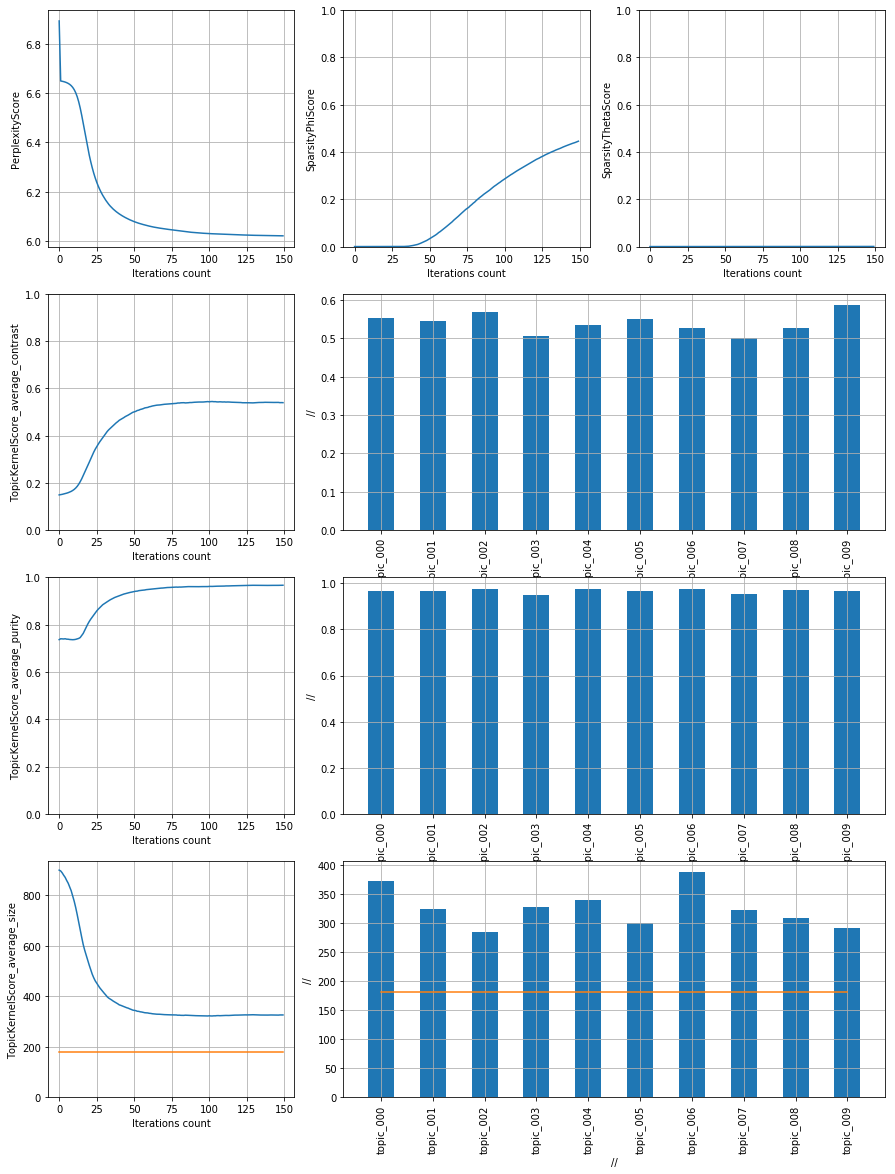

PerplexityScore: 6.020118236541748
SparsityPhiScore: 0.44584935903549194
SparsityThetaScore: 0.0005266287480480969

TopicKernelScore_average_contrast: 0.5395618677139282
TopicKernelScore_average_purity: 0.9670639038085938
TopicKernelScore_average_size: 326.70001220703125

TopTokensScore:
topic_000: использовать следовать отсутствие вывод любой история специалист мало высокий полный 
topic_001: партия призыв публичный открытый вконтакте выборы ненависть инфо оппозиционер социальный 
topic_002: освобождать отменять юрий удовлетворять компенсация сообщество освобождение эпизод обвинительный половина 
topic_003: особо предприятие бизнесмен мошенничество министр миллион должность рабочий чиновник счет 
topic_004: бить вернуться пойти увидеть сначала сидеть позвонить уезжать след вещество 
topic_005: превышение подросток умирать тяжкий служебный скончаться травма причинение девочка несовершеннолетний 
topic_006: помнить нужно здесь задавать напоминать думать обращать хорошо читать обсуждать 

In [7]:
# Создание базовой пустой модели
model_artm = new_default_model(params['topic_count'], dictionary)

# Модель 0_0
# Запуск регуляризатора SparsePhi

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=150)

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_0")
model_artm_0_0 = model_artm.clone()

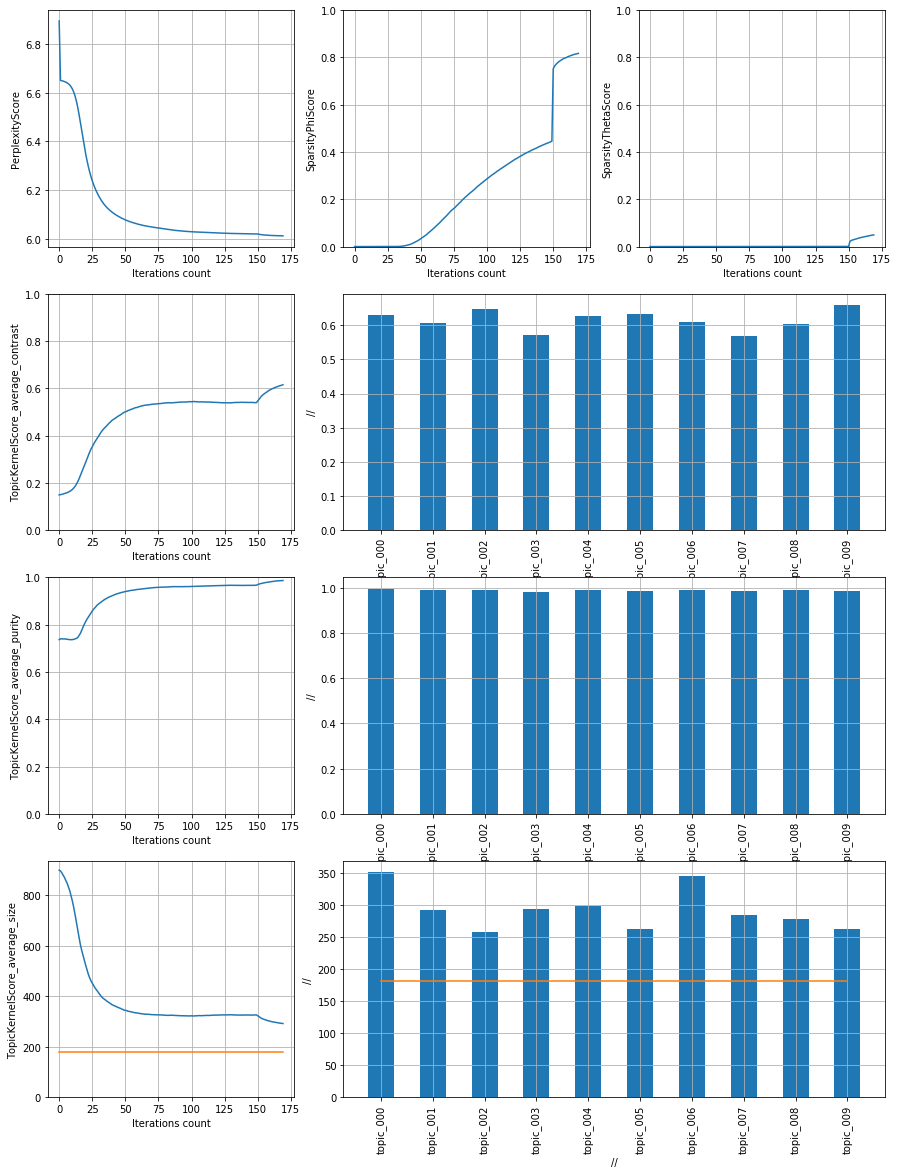

PerplexityScore: 6.012410640716553
SparsityPhiScore: 0.8172072768211365
SparsityThetaScore: 0.0494011715054512

TopicKernelScore_average_contrast: 0.6153569221496582
TopicKernelScore_average_purity: 0.9870585203170776
TopicKernelScore_average_size: 292.70001220703125

TopTokensScore:
topic_000: использовать следовать отсутствие любой мало разный вывод полный история высокий 
topic_001: партия призыв публичный открытый вконтакте выборы социальный ненависть инфо оппозиционер 
topic_002: отменять освобождать юрий сообщество удовлетворять компенсация освобождение половина эпизод обвинительный 
topic_003: особо предприятие бизнесмен мошенничество должность министр миллион рабочий чиновник занимать 
topic_004: бить сначала вернуться увидеть пойти сидеть позвонить уезжать домой след 
topic_005: превышение подросток умирать скончаться тяжкий служебный травма повреждение причинение девочка 
topic_006: помнить нужно здесь задавать напоминать обращать думать видеозапись хорошо читать 
topic_007: 

In [8]:
# Модель 0_1
# Запуск регуляризатора SparsePhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора, если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_1")
model_artm_0_1 = model_artm.clone()

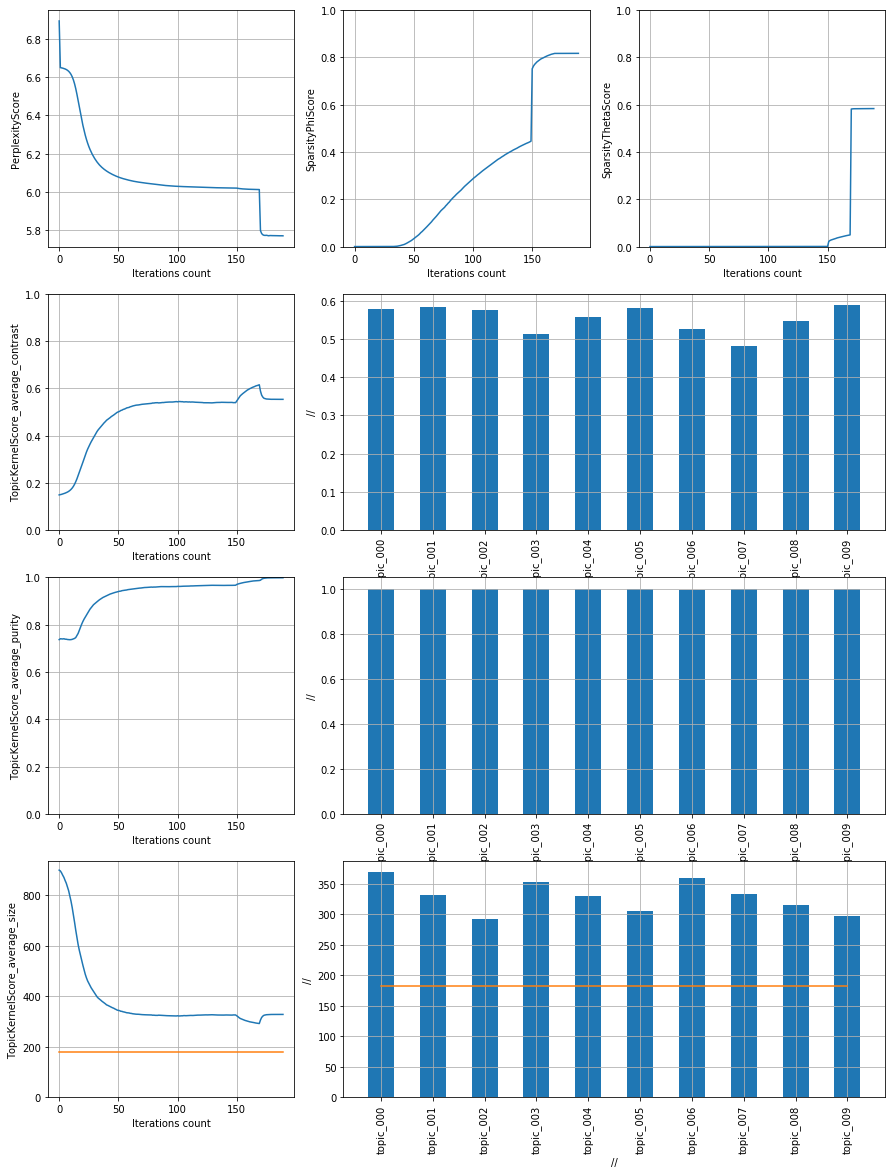

PerplexityScore: 5.770474433898926
SparsityPhiScore: 0.8175371289253235
SparsityThetaScore: 0.5838358998298645

TopicKernelScore_average_contrast: 0.5536395311355591
TopicKernelScore_average_purity: 0.9987163543701172
TopicKernelScore_average_size: 328.79998779296875

TopTokensScore:
topic_000: следовать использовать любой история высокий вывод например полный тюрьма специалист 
topic_001: призыв публичный партия вконтакте выборы открытый ненависть оппозиционер инфо оштрафовать 
topic_002: отменять освобождать компенсация удовлетворять освобождение эпизод обвинительный половина сообщество мосгорсуд 
topic_003: предприятие особо бизнесмен мошенничество министр должность миллион рабочий договор счет 
topic_004: бить вернуться пойти сначала увидеть сидеть позвонить след пакет домой 
topic_005: подросток превышение умирать тяжкий травма скончаться причинение девочка несовершеннолетний скорый 
topic_006: помнить здесь задавать думать хорошо читать обращать зачитывать обсуждать конечно 
topi

In [9]:
# Модель 0_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

# Загрузка модели
model_artm = model_artm_0_1.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_2")
model_artm_0_2 = model_artm.clone()

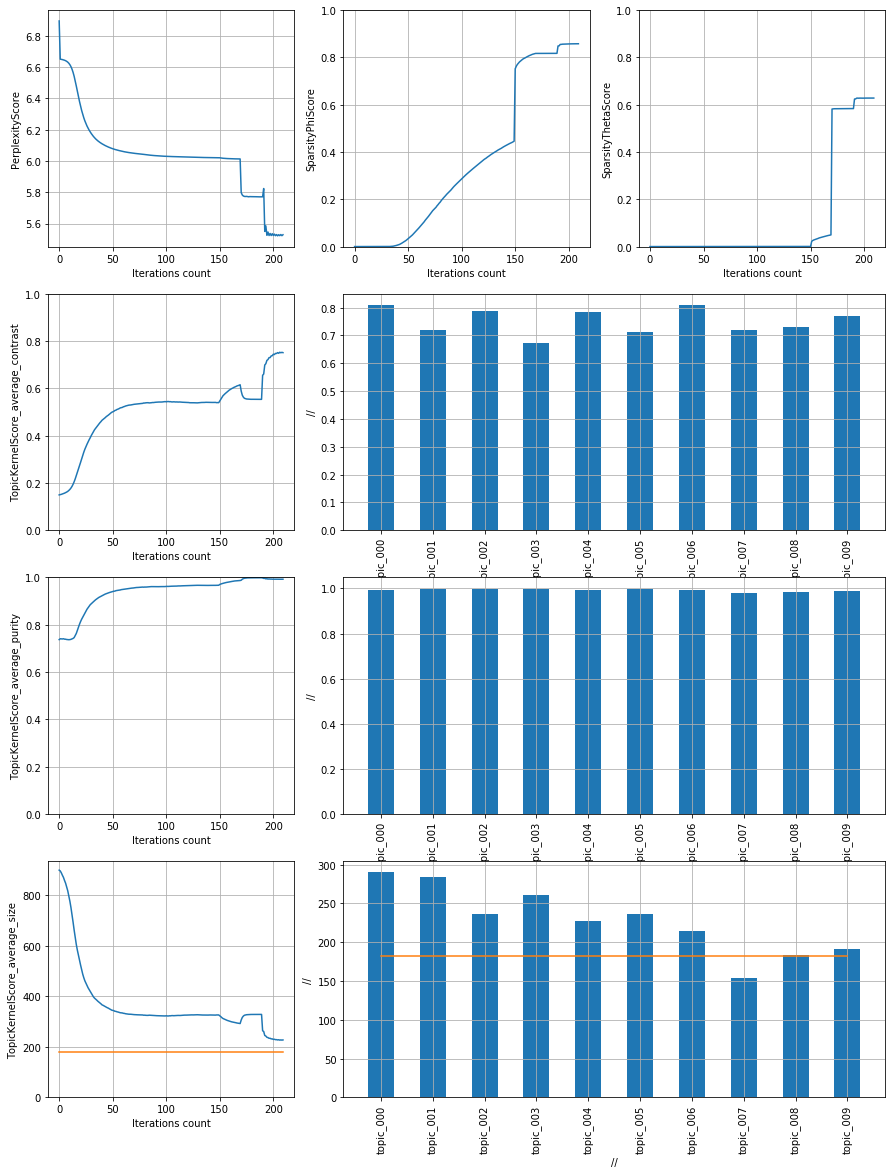

PerplexityScore: 5.528274059295654
SparsityPhiScore: 0.8581638336181641
SparsityThetaScore: 0.6283445358276367

TopicKernelScore_average_contrast: 0.7511798143386841
TopicKernelScore_average_purity: 0.9926208257675171
TopicKernelScore_average_size: 227.6999969482422

TopTokensScore:
topic_000: использовать специалист вывод разный любой отсутствие следовать основной зона мало 
topic_001: призыв публичный партия социальный вконтакте выборы открытый поддержка ненависть канал 
topic_002: юрий сообщество соглашаться отменять освобождать удовлетворять компенсация доказывать иван освобождение 
topic_003: предприятие особо бизнесмен мошенничество министр миллион занимать должность рабочий договор 
topic_004: сидеть бить увидеть вернуться пойти сначала уезжать позвонить подходить приходиться 
topic_005: подросток ударять повреждение умирать превышение тяжкий травма причинение скончаться служебный 
topic_006: помнить нужно задавать здесь напоминать думать видеозапись читать хорошо встречаться 
t

In [10]:
# Модель 0_3
# Запуск регуляризатора DecorrelatorPhi к уже включенным SparsePhi, SparseTheta

# Загрузка модели
model_artm = model_artm_0_2.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_3")
model_artm_0_3 = model_artm.clone()

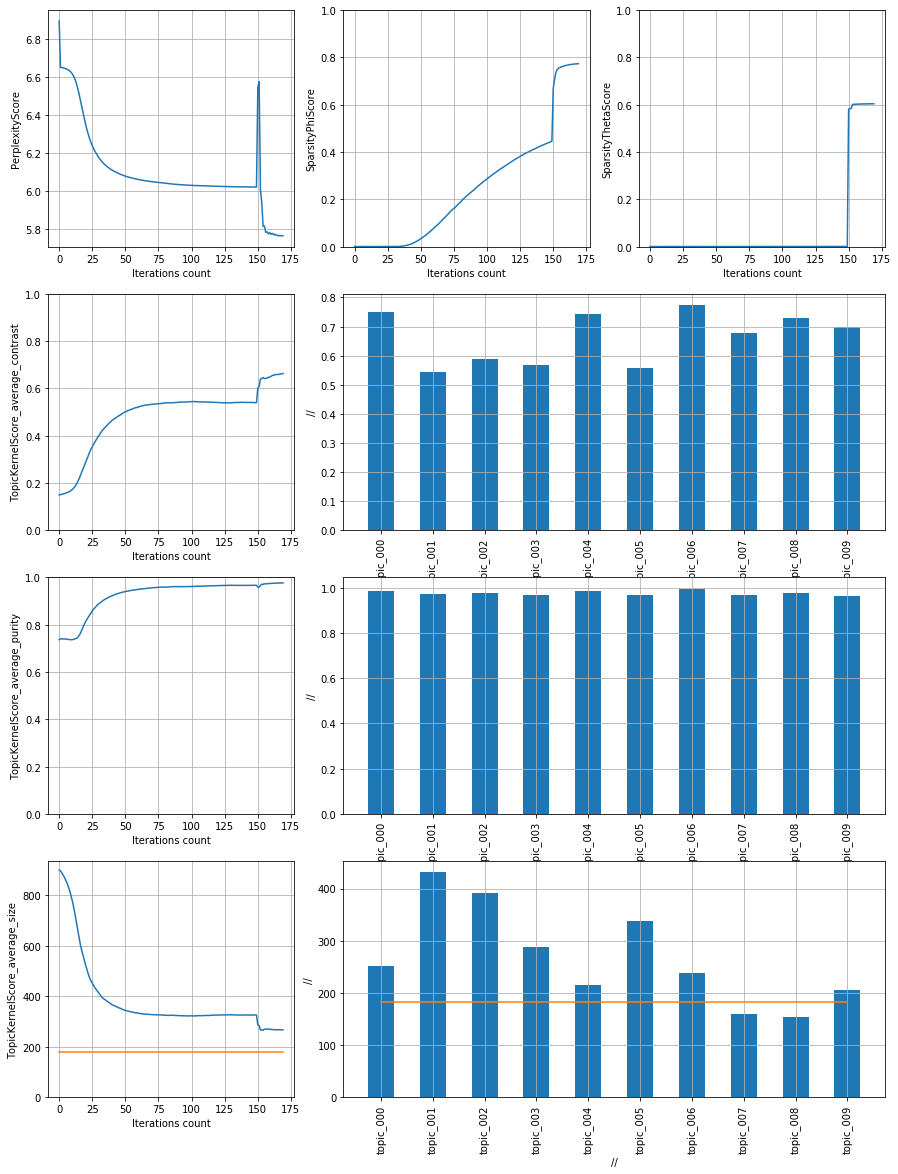

PerplexityScore: 5.764684677124023
SparsityPhiScore: 0.7739967107772827
SparsityThetaScore: 0.6042172908782959

TopicKernelScore_average_contrast: 0.6632125973701477
TopicKernelScore_average_purity: 0.9770566821098328
TopicKernelScore_average_size: 267.29998779296875

TopTokensScore:
topic_000: использовать специалист вывод разный любой отсутствие следовать зона основной например 
topic_001: призыв партия публичный социальный вконтакте выборы открытый поддержка ненависть канал 
topic_002: юрий сообщество подписывать прекращать создавать соглашаться отменять освобождать почти удовлетворять 
topic_003: предприятие бизнесмен особо мошенничество министр миллион коллега занимать должность рабочий 
topic_004: сидеть бить увидеть вернуться пойти сначала уезжать позвонить подходить закрывать 
topic_005: подросток повреждение превышение служебный умирать тяжкий травма скончаться причинение девочка 
topic_006: помнить вспоминать нужно минута здесь задавать снова напоминать думать видеозапись 
to

In [11]:
# Альтернативная модель 1_0
# Запуск одновременно 3 регуляризаторов SparsePhi, SparseTheta, DecorrelatorPhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_1_0")
model_artm_1_0 = model_artm.clone()

In [12]:
model_artm.phi_

,topic_000,topic_001,topic_002,topic_003,topic_004,topic_005,topic_006,topic_007,topic_008,topic_009
семейный,0.000000,0.000000,0.000000,0.000000,0.000306,0.000893,0.000000,0.000000,0.000982,0.000000
жительница,0.000000,0.000000,0.000000,0.000000,0.000000,0.007347,0.000000,0.000000,0.000000,0.000000
взыскание,0.000000,0.000000,0.002578,0.000142,0.000000,0.000000,0.000000,0.000000,0.000027,0.000000
сокращать,0.000000,0.000075,0.000538,0.002733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
вменять,0.000000,0.000781,0.002562,0.000000,0.000000,0.000141,0.000000,0.000000,0.000000,0.000000
объединение,0.000000,0.003961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
памятник,0.000000,0.003626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000098
дежурный,0.000000,0.000000,0.000000,0.000000,0.000110,0.006538,0.000000,0.000000,0.000000,0.000051
готовый,0.000000,0.000000,0.000529,0.000000,0.000000,0.000000,0.007668,0.000000,0.000000,0.000000
столкновение,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000217,0.000281,0.003757


In [15]:
theta = model_artm.get_theta()
theta

,9000,9001,9002,9003,9004,9005,9006,9007,9008,9009,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
topic_000,0.085609,0.113834,0.049498,1.985199e-02,0.099526,0.213888,9.760096e-02,0.031691,0.071171,0.076910,...,0.107891,0.077718,3.017841e-04,0.000009,0.070575,0.101129,0.054252,0.086480,0.038820,0.088284
topic_001,0.027584,0.331437,0.068315,1.468127e-02,0.497236,0.133909,1.191100e-01,0.002694,0.134827,0.452914,...,0.082493,0.056948,1.782970e-01,0.018120,0.326795,0.062754,0.012077,0.021852,0.071232,0.251909
topic_002,0.001463,0.134229,0.042124,2.399696e-02,0.117283,0.054023,3.707352e-08,0.128277,0.031783,0.112145,...,0.000179,0.015424,1.093325e-01,0.080891,0.033627,0.067689,0.053279,0.011724,0.023223,0.146877
topic_003,0.037541,0.026401,0.055246,8.462333e-03,0.030817,0.030121,2.112746e-02,0.123121,0.128715,0.023346,...,0.086120,0.060080,1.119920e-02,0.015264,0.036256,0.043928,0.156358,0.301493,0.487479,0.145951
topic_004,0.093569,0.045180,0.145623,2.332304e-01,0.033708,0.064642,1.625381e-01,0.267859,0.093040,0.056344,...,0.035131,0.029315,1.618126e-04,0.014017,0.225400,0.001495,0.144633,0.109986,0.041561,0.035711
topic_005,0.150500,0.072750,0.120682,4.155443e-01,0.015425,0.042401,2.456385e-01,0.209776,0.046721,0.055909,...,0.337267,0.368554,1.681552e-01,0.023120,0.027924,0.125161,0.228587,0.055893,0.007184,0.039822
topic_006,0.086249,0.061473,0.114171,2.042083e-09,0.095790,0.118864,8.605955e-02,0.062990,0.091432,0.032914,...,0.005607,0.000367,7.617113e-07,0.017270,0.109586,0.034248,0.005498,0.020706,0.010669,0.025025
topic_007,0.217766,0.137594,0.152432,1.329494e-01,0.016521,0.168667,4.064517e-02,0.043685,0.120306,0.037971,...,0.028363,0.024855,5.823893e-02,0.765212,0.037593,0.335546,0.028881,0.110835,0.154599,0.173144
topic_008,0.048167,0.037919,0.079545,5.737813e-02,0.057843,0.101489,3.976760e-02,0.025341,0.274059,0.138673,...,0.051409,0.010555,3.034486e-02,0.005947,0.026692,0.036926,0.054297,0.228887,0.061019,0.051150
topic_009,0.251551,0.039184,0.172364,9.390518e-02,0.035851,0.071995,1.875127e-01,0.104567,0.007945,0.012874,...,0.265541,0.356186,4.439681e-01,0.060151,0.105551,0.191123,0.262137,0.052144,0.104215,0.042127
